# Check Common allele frequencies and how mistakes are distributed among Labs

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
import h5py
import itertools as it

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

Current machine: compute-e-16-235.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [2]:
def filter_reliable_snps(df, frac_cov=0.75, min_alt=50,
                        alt_col="altcount", tot_col="totcount", output=True):
    """Filter to reliable SNPs
    df: Input dataframe (allele spectrum)
    frac_cov: """
    max_count = np.max(df_spec[tot_col])  # Max. Coverage
    idx = (df[alt_col]>min_alt) & (df[tot_col]>(frac_cov*max_count))
    df = df[idx].copy()
    if output:
        print(f"Max Covered: {max_count} Inds")
        print(f"Cutoff: {frac_cov*max_count}")
        print(f"Filtered to {np.sum(idx)} / {len(idx)} Variants")
    return df

def load_h5(path = "./output/h5/covid_seqs.h5"):
    """Load and return HDF5"""
    f = h5py.File(path, "r") # Load for Sanity Check. See below!  
    print(f"Loaded HDF5 from {path}")
    print(list(f))
    print(np.shape(f["gt"]))
    assert(np.shape(f["gt"])[0]==len(f["samples"]))
    return f

def load_spectrum_df(path_spectrum = "./output/tables/allele_spectrum.tsv"):
    """Load and process Spectrum Dataframe. Return dataframe"""
    df_spec = pd.read_csv(path_spectrum, sep="\t")
    print(f"Loaded {len(df_spec)} Loci Statistics from {path_spectrum}")
    df_spec["totcount"] = (df_spec["refcount"] + df_spec["altcount"])  # Create the total Count
    max_count = np.max(df_spec["totcount"])
    print(f"Maximum Covered Locus: {max_count} Inds")
    return df_spec

def create_int_df(f, df_snps, h5_field="gt", ref_id = "Wuhan-Hu-1", 
                  sample_field="samples"):
    """Produce ref derived 0/1 counts for
    allele frequency file f and variant datafram df_snps"""
    n, _ = np.shape(f[h5_field])
    l = len(df_snps)
    gt = -np.ones((n,l), dtype="int8")
    g = f[h5_field][:, df_snps["pos"]]
    ref_idx = (g == df_snps["ref"].astype('|S1').values[None,:])
    alt_idx = (g == df_snps["alt"].astype('|S1').values[None,:])

    ## Sanity Checks
    assert(np.sum(ref_idx, axis=0)==df_snps["refcount"].values).all()
    assert(np.sum(alt_idx, axis=0)==df_snps["altcount"].values).all()
    
    ### Flip Allele to Reference if required (where alt sequence is matching)
    if len(ref_id)>0:
        idx = [(ref_id in s)  for s in f[sample_field]]
        assert(np.sum(idx)==1) # Sanity check
        g_ref = f[h5_field][:, df_snps["pos"]][idx,:][0]

        g_ref0 = df_snps["alt"].astype('|S1').values[None,:][0]
        flip_idx = (g_ref == g_ref0)
        ref_idx[:,flip_idx], alt_idx[:,flip_idx] = alt_idx[:,flip_idx], ref_idx[:,flip_idx]
        print(f"Flipped {np.sum(flip_idx)} Loci to {ref_id}")

    gt[ref_idx]=0
    gt[alt_idx]=1
    return gt


##################################################

def return_der_stats(g1, g2, cov_only=True):
    """Calculate and return statistics
    of ancestral/derived.
    g1, g2: Arrays of Genotypes (0/1/-1)"""
    if cov_only:
        idx = (g1>=0) & (g2>=0)
        g1, g2 = g1[idx], g2[idx] 
    d1 = (g1 == 1)
    d2 = (g2 == 1)
    td1, td2 = np.sum(d1), np.sum(d2)  # How many are derived
    
    both_d = np.sum(d1 & d2)
    min_d = np.min([td1,td2])
    min_idx = np.argmin([td1,td2])
    
    return both_d, min_d, min_idx

def calc_pw_stats(gt):
    """Calculate pw. Loci statistics for Genotypes gt (n,l).
    Return Matrix of minimum derived allele, both_derived allele, and fraction"""
    assert(len(np.shape(gt))==2)  # Sanity Check if Genotype Matrix
    
    l = np.shape(gt)[1]
    both_ds, min_ds = np.zeros((l,l), dtype="int"), np.zeros((l,l),dtype="int")
    fracs = np.zeros((l,l),dtype="float")
    
    for (i1,i2) in it.combinations(range(l),2):
        both_d, min_d, min_idx = return_der_stats(gt[:,i1], gt[:,i2], cov_only=True)
        
        both_ds[i1,i2]=both_d
        min_ds[i1,i2]=min_d
    
    ### Mirror Values
    min_ds = min_ds + min_ds.T
    both_ds = both_ds + both_ds.T
        
    ### Do the Diagonal
    for i in range(l):
        min_ds[i,i] = np.sum(gt[:,i]*(gt[:,i]>=0))
        both_ds[i,i] = np.sum(gt[:,i]*(gt[:,i]>=0))
    assert(np.min(min_ds)>0)  # To make sure only derived Markers where in there
    fracs = both_ds / min_ds
    return both_ds, min_ds, fracs

# Load common alleles & clean data

In [3]:
df_spec = load_spectrum_df(path_spectrum = "./output/tables/allele_spectrum.tsv")

Loaded 29903 Loci Statistics from ./output/tables/allele_spectrum.tsv
Maximum Covered Locus: 15052 Inds


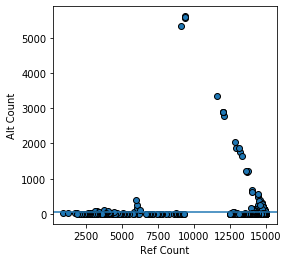

In [11]:
plt.figure(figsize=(4,4))
ax=plt.gca()
ax.scatter(df_spec["refcount"], df_spec["altcount"], ec='k')
ax.set_xlabel("Ref Count")
ax.set_ylabel("Alt Count")
ax.axhline(50)
#ax.set_ylim([0,1500])
plt.show()

# Analyze SNPs on 0/1/-1 basis

In [19]:
%time
df_spec = load_spectrum_df(path_spectrum = "./output/tables/allele_spectrum.tsv")
df_snps = filter_reliable_snps(df_spec, frac_cov=0.75, min_alt=100)
f = load_h5(path = "./output/h5/covid_seqs.h5")  # Now load the hdf5

### Load relevant parts of the HDF5
gt = create_int_df(f, df_snps, ref_id='Wuhan-Hu-1')  # Create 0/1 Genotype Matrix [n,l] for df_snps Positions
np.shape(gt)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs
Loaded 29903 Loci Statistics from ./output/tables/allele_spectrum.tsv
Maximum Covered Locus: 15052 Inds
Max Covered: 15052 Inds
Cutoff: 11289.0
Filtered to 74 / 29903 Variants
Loaded HDF5 from ./output/h5/covid_seqs.h5
['gt', 'samples']
(15056, 29903)
Flipped 4 Loci to Wuhan-Hu-1


(15056, 74)

### Load and plot pw. Loci stats for these common alleles

In [20]:
both_ds, min_ds, fracs = calc_pw_stats(gt)

In [26]:
def plot_derived_pairs(both_df, min_ds, ylim=[]):
    """Plot # both derived vrs minimum derived"""
    plt.figure(figsize=(4,4))
    ax = plt.gca()
    ax.scatter(min_ds.flatten(), both_ds.flatten(), ec="k", zorder=1)
    ax.set_xlabel("Minimum # Derived Individuals")
    ax.set_ylabel(" #Both Indiivdiual Dervied")
    ax.set_title("All Pairs of Markers")
    m = np.max(min_ds)
    ax.plot([0,m],[0,m], c="silver", zorder=0)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    plt.show()

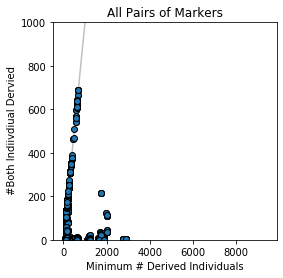

In [31]:
plot_derived_pairs(both_ds, min_ds, ylim=[0,1000])

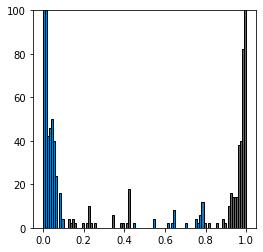

In [32]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.hist(fracs.flatten(), bins=100, ec="k")
ax.set_ylim([0,100])
plt.show()

# Plot Inconsistencies between Loci

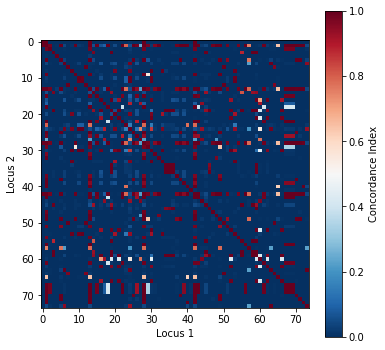

In [33]:
both_ds, min_ds, fracs =calc_pw_stats(gt)

fig = plt.figure(figsize=(6,6))
ax=plt.gca()
#fig,, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=3)
pos = ax.imshow(fracs, cmap="RdBu_r")
fig.colorbar(pos, ax=ax, label="Concordance Index")
ax.set_xlabel("Locus 1")
ax.set_ylabel("Locus 2")
#fig.colorbar(pos, ax=ax1)
plt.show()

In [36]:
cts =np.sum((fracs>0.2) & (fracs<0.8), axis=0)
cts

array([ 0,  4,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,  4,  0,  0,  1,
        0,  6,  1,  0,  1,  1,  5,  2,  0,  0,  7,  4,  5,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  2,  0,  4,  1,  0,  0,  0,  0,  1,  2,  0,
        0,  1,  0,  0,  0,  0,  9,  0,  1, 10,  1,  1,  1,  0,  5,  1,  2,
        2,  2,  0,  0,  0,  1])

In [37]:
idx = np.where(cts>=5)[0]
df_snps.iloc[idx,:]

,refcount,altcount,ref,alt,pos,totcount
7437,14881,138,t,c,7437,15019
10322,14793,127,a,g,10322,14920
13729,14885,130,c,t,13729,15015
14785,14887,135,c,t,14785,15022
27963,14774,205,c,t,27963,14979
28310,14835,188,c,t,28310,15023
28853,14792,208,c,t,28853,15000


# Look only at the Belgium Samples

In [175]:
ctry="Belgium"
d=10

idx = [ctry in s for s in f["samples"]]
print(f"Extract {np.sum(idx)} / {len(idx)} Samples")

gt_b = gt[idx,:]
idx_g = np.sum(gt_b*(gt_b>=0), axis=0)>=d
gt_b = gt_b[:,idx_g]
print(f"Extract {np.sum(idx_g)} / {len(idx_g)} Individuals with more than {d} derived Markers")
df_snps_b = df_snps[idx_g].copy()

Extract 288 / 4954 Samples
Extract 19 / 47 Individuals with more than 10 derived Markers


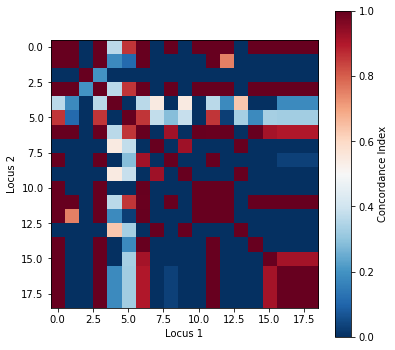

In [176]:
both_ds, min_ds, fracs =calc_pw_stats(gt_b)

fig = plt.figure(figsize=(6,6))
ax=plt.gca()
#fig,, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=3)
pos = ax.imshow(fracs, cmap="RdBu_r")
fig.colorbar(pos, ax=ax, label="Concordance Index")
ax.set_xlabel("Locus 1")
ax.set_ylabel("Locus 2")
#fig.colorbar(pos, ax=ax1)
plt.show()

In [177]:
cts =np.sum((fracs>0.1) & (fracs<0.9), axis=0)
cts

array([ 2,  3,  1,  3, 12, 14,  2,  2,  1,  2,  0,  2,  2,  2,  1,  1,  2,
        2,  2])

In [179]:
idx = np.where(cts>=5)[0]
df_snps_b.iloc[idx,:]

,refcount,altcount,ref,alt,pos,totcount
11082,4223,687,g,t,11082,4910
13401,4636,51,t,g,13401,4687


In [158]:
#df_snps_b.iloc[[4,5,6, 8,12],:]
df_snps_b.iloc[-3:,:]

,refcount,altcount,ref,alt,pos,totcount
28880,4111,802,g,a,28880,4913
28881,4118,800,g,a,28881,4918
28882,4118,800,g,c,28882,4918


### Screen

In [35]:
co_derived = np.sum(fracs>0.8, axis=1)
idx_prob = co_derived==1
np.where(idx_prob)

(array([15, 18, 33]),)

In [33]:
df_snps[co_derived==1]

,refcount,altcount,ref,alt,pos,totcount
13401,4636,51,t,g,13401,4687
15323,4727,222,c,t,15323,4949
26529,4856,62,a,g,26529,4918


# Idea Reconstruct the Tree of mutations

# Idea: Lab specific Mutation Tree


# Area 51

In [52]:
"lol" in "lo1l1ol"

False

### Test Loading hdf5

In [2]:
path="/home/np29/myhdf5/2bit_uchar.h5"
f = h5py.File(path, "r") # Load for Sanity Check. See below!  
print(f"Loaded HDF5 from {path}")
print(list(f))

Loaded HDF5 from /home/np29/myhdf5/2bit_uchar.h5
['2bit']


In [4]:
f["2bit"][:]

array([[0, 1],
       [2, 3],
       [0, 1]], dtype=uint8)

In [36]:
a = [0, 1, 1, 1, 0]
b= [0, 0, 1, 0, 0]

np.corrcoef(a,b)

array([[1.        , 0.40824829],
       [0.40824829, 1.        ]])